In [1]:
import numpy as np
from astropy.table import Table

Implemented the first try of using alternative weights. Running over 10k objects, regular `r`, no shift correction.

In [2]:
r = Table.read('/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means_r_float32.fits')

In [3]:
usedAlternative = r[r['AlternativeWeightFlag'] == True]

In [4]:
len(usedAlternative)

56

Let's see how far are they.

In [5]:
f_err = usedAlternative['CoaddedPdz_50'] - usedAlternative['z_true']
f_err = f_err[np.isnan(f_err) == False]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = [15, 10]

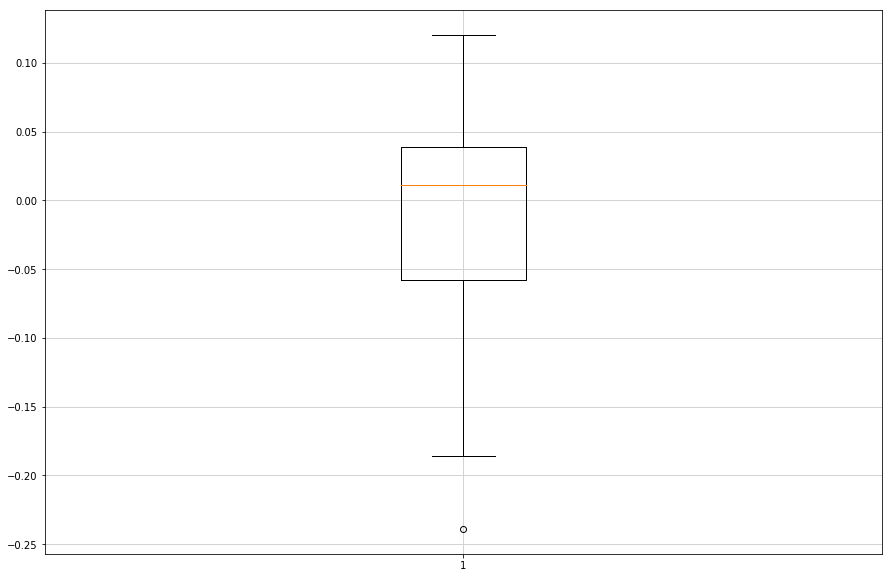

In [7]:
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
_ = plt.boxplot([f_err.data])

However, there are still some NaN... :/

In [8]:
nan_entries = usedAlternative[np.isnan(usedAlternative['CoaddedPdz_50'])]

In [9]:
nan_entries

CoaddedPdz [601],CoaddedPdz_25,CoaddedPdz_50,CoaddedPdz_mc [100],AlternativeWeightFlag,mean_u,mean_u_ERR,mean_g,mean_g_ERR,mean_r,mean_r_ERR,mean_i,mean_i_ERR,mean_z,mean_z_ERR,mean_vis,mean_vis_ERR,mean_Y,mean_Y_ERR,mean_J,mean_J_ERR,mean_H,mean_H_ERR,NeighborIDs [30],NeighborWeights [30],ID,u,g,r,i,z,vis,Y,J,H,r_shift0,r_shift1,r_shift2,r_shift3,r_shift4,r_shift5,r_shift6,r_shift7,r_shift8,r_shift9,r_widening0,r_widening1,r_widening2,r_widening3,r_widening4,r_widening5,r_widening6,r_widening7,r_widening8,r_widening9,r_skewing0,r_skewing1,r_skewing2,r_skewing3,r_skewing4,r_skewing5,r_skewing6,r_skewing7,r_skewing8,r_skewing9,r_softening0,r_softening1,r_softening2,r_softening3,r_softening4,r_softening5,r_softening6,r_softening7,r_softening8,r_softening9,ra,dec,z_true,has_spec_z,weight,radius,r_shift7_obs_mag_err,r_widening8_obs_mag,r_skewing9_obs_err,r_softening1_obs_mag,r_softening5_obs,r_softening8_obs_err,r_skewing3_obs_mag_err,r_shift0_obs_mag_err,r_softening9_obs_err,r_skewing8_obs_err,r_shift1_obs_err,r_skewing0_obs,r_shift9_obs_err,r_skewing6_obs_mag,i_obs_mag,r_widening0_obs_err,r_softening0_obs,r_widening7_obs_mag,r_skewing5_obs_mag,J_obs_mag_err,i_obs,r_softening1_obs,r_skewing8_obs_mag,r_softening4_obs_mag_err,z_obs_mag,r_widening6_obs_mag_err,r_softening5_obs_err,r_skewing1_obs,r_shift3_obs_mag,r_widening8_obs_mag_err,r_widening3_obs_mag,r_widening3_obs_mag_err,r_skewing2_obs_err,r_softening4_obs_mag,r_widening6_obs_mag,r_skewing6_obs_err,r_softening3_obs_err,r_widening8_obs,r_skewing4_obs_mag_err,r_softening0_obs_mag,r_shift0_obs,Y_obs_mag,r_skewing5_obs_err,r_shift6_obs_mag_err,g_obs_mag,r_skewing1_obs_mag,r_softening0_obs_mag_err,g_obs,r_softening1_obs_mag_err,u_obs_mag_err,r_shift7_obs,r_widening4_obs_mag_err,i_obs_mag_err,r_obs,r_obs_err,r_widening0_obs_mag,r_widening6_obs_err,r_softening5_obs_mag,r_widening5_obs_mag,r_softening5_obs_mag_err,r_softening7_obs_err,r_widening5_obs_err,r_skewing7_obs_err,r_widening4_obs,r_softening6_obs_err,H_obs_mag,r_widening6_obs,g_obs_err,r_softening8_obs_mag_err,r_skewing0_obs_mag,r_widening5_obs_mag_err,r_softening2_obs_mag_err,H_obs_mag_err,r_widening9_obs,r_skewing1_obs_mag_err,r_softening6_obs_mag,r_skewing9_obs,r_shift0_obs_err,vis_obs_mag_err,r_shift5_obs_err,r_widening2_obs_err,r_widening8_obs_err,r_skewing8_obs_mag_err,r_widening3_obs,r_skewing6_obs_mag_err,r_softening9_obs,r_skewing3_obs_err,r_skewing0_obs_mag_err,r_shift8_obs_mag_err,r_widening1_obs_err,r_widening2_obs_mag_err,r_softening6_obs,r_widening2_obs,r_shift8_obs_err,r_widening2_obs_mag,r_skewing8_obs,r_softening3_obs_mag,r_skewing3_obs,r_shift2_obs_err,r_skewing7_obs,r_skewing7_obs_mag,r_softening0_obs_err,r_softening7_obs_mag_err,r_shift6_obs,r_softening3_obs_mag_err,r_skewing1_obs_err,r_shift3_obs_err,r_shift8_obs,r_skewing4_obs_mag,r_shift6_obs_mag,r_shift4_obs_err,r_softening4_obs,r_shift1_obs_mag_err,r_shift5_obs_mag_err,r_skewing4_obs_err,r_skewing0_obs_err,r_shift9_obs_mag_err,r_skewing4_obs,r_shift9_obs,J_obs,r_shift9_obs_mag,r_softening8_obs_mag,r_shift5_obs_mag,r_softening4_obs_err,r_widening7_obs_err,r_widening9_obs_mag_err,H_obs_err,r_widening9_obs_mag,z_obs_mag_err,r_obs_mag,vis_obs,Y_obs_err,z_obs,Y_obs_mag_err,r_softening2_obs,r_shift4_obs,u_obs_err,r_softening3_obs,r_softening6_obs_mag_err,r_shift6_obs_err,r_skewing9_obs_mag,r_shift4_obs_mag_err,vis_obs_mag,r_shift3_obs_mag_err,r_widening4_obs_err,r_shift1_obs_mag,J_obs_err,H_obs,r_softening1_obs_err,r_softening2_obs_mag,r_shift8_obs_mag,r_shift2_obs_mag_err,u_obs_mag,g_obs_mag_err,r_shift2_obs_mag,Y_obs,z_obs_err,r_softening9_obs_mag,r_skewing5_obs,r_shift3_obs,r_widening4_obs_mag,J_obs_mag,r_widening1_obs,r_widening0_obs,r_shift5_obs,r_softening9_obs_mag_err,r_shift4_obs_mag,u_obs,r_shift0_obs_mag,r_skewing2_obs_mag,r_widening3_obs_err,vis_obs_err,r_widening1_obs_mag_err,r_shift7_obs_err,r_shift2_obs,r_skewing7_obs_mag_err,r_widening5_obs,r_softening7_obs_mag,r_widening9_obs_err,r_shift7_obs_mag,r_widening1_obs_mag,r_skewing2_obs_mag_err,

In [10]:
nan_entries['NeighborWeights'][0]

array([  1.74381062e-059,   2.82273336e-245,   5.81898684e-190,
         2.09795850e-184,   1.37315660e-232,   7.52849974e-255,
         1.80770996e-126,   1.28939844e-220,   2.39081152e-200,
         1.34076564e-230,   2.67678390e-276,   2.03599888e-181,
         8.03893718e-233,   2.46668017e-234,   9.34855535e-210,
         9.90718902e-236,   6.06593872e-291,   1.07905742e-270,
         3.69154750e-217,   2.17474384e-146,   5.11750743e-270,
         9.61408362e-263,   1.00770161e-096,   1.40944721e-276,
         4.43130651e-245,   1.57279554e-149,   1.05764257e-216,
         2.24767664e-145,   2.05587029e-285,   4.70750561e-266])

Probably it is because here:

```python
self.__pdzs[catalog_i] += self.__current_ref_pdz[:, 1] * weight
```

If weight is sooo small, and the pdz is small enough too, it basically results in 0

In [11]:
from nnpz.reference_sample.ReferenceSample import ReferenceSample

In [12]:
ref = ReferenceSample('/home/aalvarez/Work/Data/dc3/ReferenceSample/')

In [13]:
print(nan_entries['NeighborIDs'][0][0])
print(nan_entries['NeighborWeights'][0][0], type(nan_entries['NeighborWeights'][0][0]))

226709
1.74381062454e-59 <class 'numpy.float64'>


In [14]:
pdz = ref.getPdzData(226709)
print(type(pdz[0][0]))
after = pdz * nan_entries['NeighborWeights'][0][0]
print(after)

<class 'numpy.float32'>
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [15]:
after[after != 0]

array([], dtype=float32)

In [16]:
sum(np.isnan(r['CoaddedPdz_50']))

12

## Trying with float64 and casting back to float32 after normalization

In [18]:
r64 = Table.read('/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means_r.fits')
sum(np.isnan(r64['CoaddedPdz_50']))

0

We can see that there are no nans anymore! Also, there are no more complains during the execution.

In [19]:
usedAlternative64 = r64[r64['AlternativeWeightFlag'] == True]
len(usedAlternative64)

56

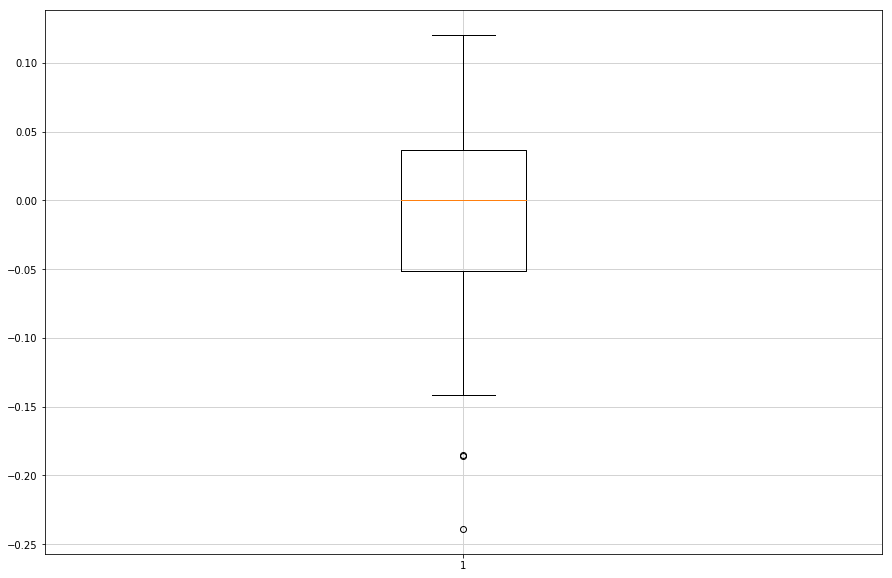

In [22]:
f64_err = usedAlternative64['CoaddedPdz_50'] - usedAlternative64['z_true']
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
_ = plt.boxplot([f64_err.data])

Even looks better. We are not losing target entries, and the error doesn't get worse.